In [8]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.optimize import minimize

# Given data
x_data = np.array([201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146])
y_data = np.array([592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344])
y_errors = np.array([61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22])

def quadratic_model(parameters, x):
    a_coeff, b_coeff, c_coeff = parameters
    return a_coeff * x**2 + b_coeff * x + c_coeff

def log_likelihood(parameters, x, y, y_errors):
    model_values = quadratic_model(parameters, x)
    variance = y_errors**2
    return -0.5 * np.sum((y - model_values)**2 / variance + np.log(2 * np.pi * variance))

def log_prior(parameters):
    return 0

def log_posterior(parameters, x, y, y_errors):
    prior_log = log_prior(parameters)
    if not np.isfinite(prior_log):
        return -np.inf
    return prior_log + log_likelihood(parameters, x, y, y_errors)

num_dimensions = 3
num_walkers = 50
num_steps = 4000

# Initializing
initial_guess = np.array([0.0, 3.0, 100.0])
neg_log_likelihood = lambda *args: -log_likelihood(*args)
solution = minimize(neg_log_likelihood, initial_guess, args=(x_data, y_data, y_errors))
initial_positions = solution.x + 1e-4 * np.random.randn(num_walkers, num_dimensions)

# Create the sampler
mcmc_sampler = emcee.EnsembleSampler(num_walkers, num_dimensions, log_posterior, args=(x_data, y_data, y_errors))

# Run the MCMC sampler
mcmc_sampler.run_mcmc(initial_positions, num_steps, progress=True)

# Analyze the results
mcmc_samples = mcmc_sampler.get_chain()


You must install the tqdm library to use progress indicators with emcee


Text(0.5, 0, 'Step number')

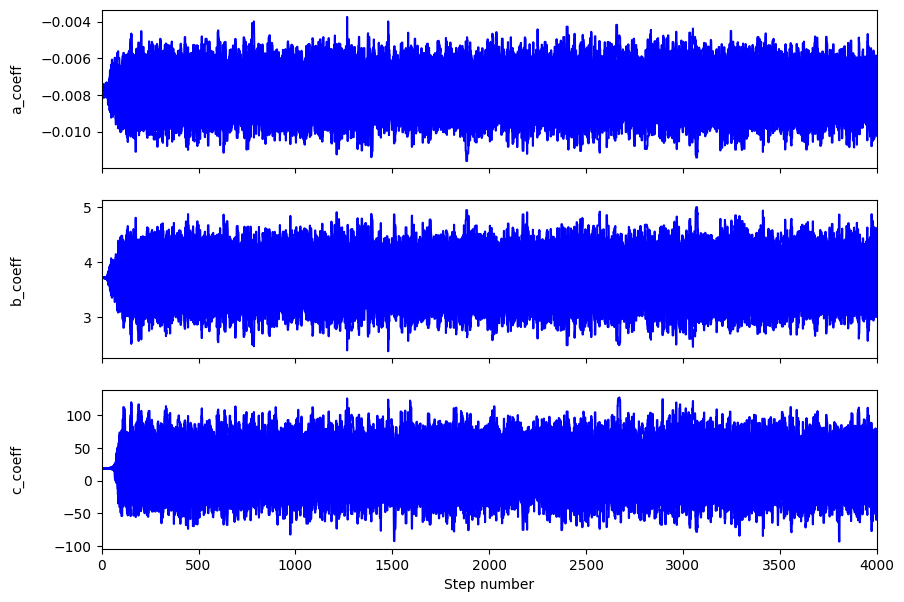

In [9]:
# Plotting the chains
fig, axes = plt.subplots(num_dimensions, figsize=(10, 7), sharex=True)
parameter_labels = ['a_coeff', 'b_coeff', 'c_coeff']
for dim_index in range(num_dimensions):
    ax = axes[dim_index]
    ax.plot(mcmc_samples[:, :, dim_index], 'b')
    ax.set_xlim(0, len(mcmc_samples))
    ax.set_ylabel(parameter_labels[dim_index])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel('Step number')


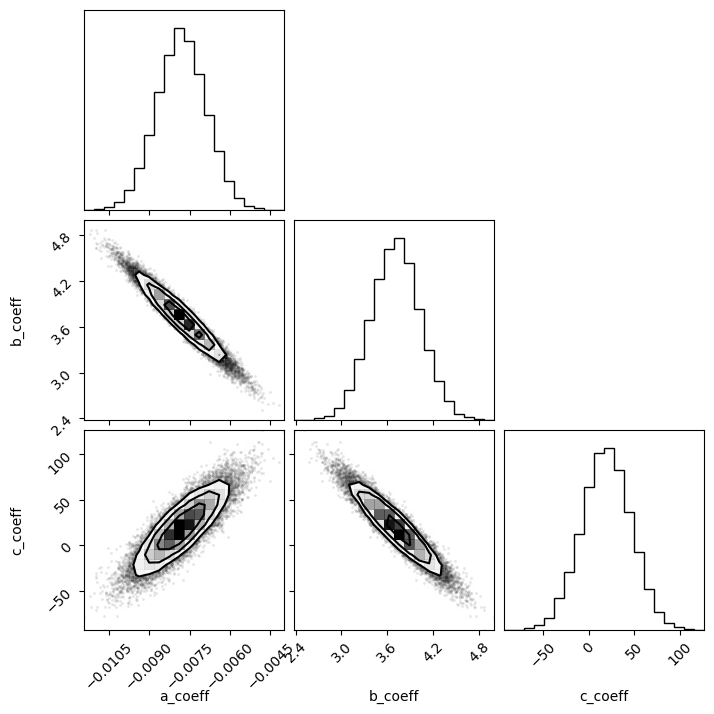

The median values of the parameters are:
a_coeff: -0.008,  b_coeff: 3.713, c_coeff: 19.227
The one sigma uncertainties are:
a_coeff: (-0.001, +0.001), b_coeff: (-0.319, +0.314), c_coeff: (-26.629, +26.786)


In [10]:
# Plot the corner plot
flat_samples = mcmc_sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=parameter_labels)
plt.show()

a_median, b_median, c_median = np.median(flat_samples, axis=0)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)
a_err_min, a_err_max = np.diff(percentiles[:, 0])
b_err_min, b_err_max = np.diff(percentiles[:, 1])
c_err_min, c_err_max = np.diff(percentiles[:, 2])

print("The median values of the parameters are:")
print(f"a_coeff: {a_median:.3f},  b_coeff: {b_median:.3f}, c_coeff: {c_median:.3f}")
print("The one sigma uncertainties are:")
print(f"a_coeff: (-{a_err_min:.3f}, +{a_err_max:.3f}), b_coeff: (-{b_err_min:.3f}, +{b_err_max:.3f}), c_coeff: (-{c_err_min:.3f}, +{c_err_max:.3f})")


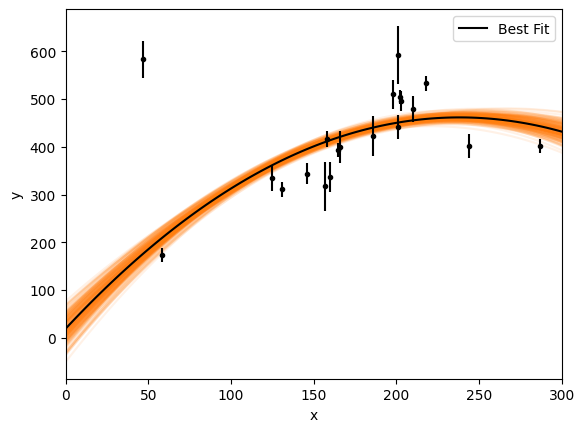

In [11]:
random_indices = np.random.randint(len(flat_samples), size=200)
x_range = np.linspace(0, 300, 100)
for index in random_indices:
    sample_parameters = flat_samples[index]
    plt.plot(x_range, np.dot(np.vander(x_range, 3), sample_parameters[:3]), 'C1', alpha=0.1)
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='.k', capsize=0)
plt.plot(x_range, quadratic_model([a_median, b_median, c_median], x_range), 'k', label='Best Fit')
plt.legend()
plt.xlim(0, 300)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
